In [1]:
%load_ext autoreload
%autoreload 2

## Load pythae

In [13]:
import sys
import os

# Add the project root directory to the Python path
pythae_path = '/Users/louis/Documents/Phd/Code_pour_manuscript/benchmark_VAE/src'
sys.path.insert(0, pythae_path)

from pythae.models import VAAE, VAAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn import EncoderVAAE

import numpy as np
import scipy
import matplotlib.pyplot as plt

In [14]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [15]:
y = []
for i in range(100):
    # Sample from the Gaussian process distribution
    nb_of_samples = 100  # Number of points in each function
    number_of_functions = 10  # Number of functions to sample
    # Independent variable samples
    X = np.expand_dims(np.linspace(-.1*nb_of_samples, .1*nb_of_samples, nb_of_samples), 1)
    Σ = exponentiated_quadratic(X, X)  # Kernel of data points

    # Draw samples from the prior at our data points.
    # Assume a mean of 0 for simplicity
    ys = np.random.multivariate_normal(
        mean=np.zeros(nb_of_samples), cov=Σ, 
        size=number_of_functions)
    #print(ys.shape)
    y += [ys.T]

In [16]:
ys = np.concatenate(y)

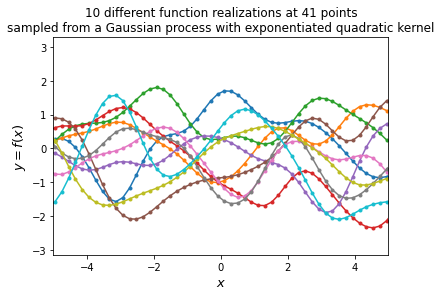

In [17]:
# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, y[0][:,i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    f'{number_of_functions} different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-5, 5])
plt.show()
#

In [18]:
## make them into 20 features
X_total = []
for i in range(5):
    X = np.random.rand(2,2)
    x = X@ys.T[2*i:2*(i+1)]
    X_total += [x]
    print(x.shape)

(2, 10000)
(2, 10000)
(2, 10000)
(2, 10000)
(2, 10000)


In [19]:
X_total = np.concatenate(X_total).T
X_total.shape

(10000, 10)

In [20]:
X_normalized=(X_total-X_total.mean())/X_total.std()

In [24]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model_config = VAAEConfig(
    input_dim=(1,X_normalized.shape[-1]),
    latent_dim=32
)

encoder = EncoderVAAE(model_config)
encoder.nan_token = 0

model = VAAE(
    model_config=model_config, 
    encoder = encoder) #,encoder = Encoder_VAE_MLP

model.to(device);
model.beta = 1

#model.plotter.x_true = torch.tensor(X_normalized[:20]).detach().float()
#model.plotter.x_corr = model.DataMasker.corrupt(model.plotter.x_true)

open('log_vae.txt','a').close()

## Load Remasker dataset

In [25]:
## mask some values randomly
X_corr = model.DataMasker.corrupt(torch.tensor(X_normalized))

# split train test
from sklearn.model_selection import train_test_split

X_np, y_np = X_corr, X_corr[:,:2]
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np)

AttributeError: 'VAAE' object has no attribute 'DataMasker'

In [ ]:
import os
import glob

plots = glob.glob('plots/plot*.png')
for f in plots:
    os.remove(f)

n = 1
model.x = X_test[:20].detach().clone().float()
model.n_repeats = 10
model.p = .3
model.l = 1
#model.n_samples = 30

config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    batch_size=32,
    num_epochs=300, # Change this to train the model a bit more
)

pipeline = TrainingPipeline(
    training_config=config,
    model=model
    )

#with torch.autograd.set_detect_anomaly(True):
pipeline(
    train_data=X_train[::n],
    eval_data=X_test[::n],
    train_label=y_train[::n],
    eval_label=y_test[::n]
)

In [ ]:
## get reconstruction

x_true = torch.tensor(X_normalized[:30]).float()
x_true_corr = model.DataMasker.corrupt(x_true)

# get latent rpz
out = model.encoder(x_true_corr)
mu, var = out.embedding, out.covariance
std_norm = var**.5
z_min, z, z_max = mu - 2*std_norm, mu, mu + 2*std_norm

# get output
x_recon = model.decoder(z).reconstruction.reshape(x_true.shape).detach()
x_recon_min = model.decoder(z_min).reconstruction.reshape(x_true.shape).detach()
x_recon_max = model.decoder(z_max).reconstruction.reshape(x_true.shape).detach()



In [ ]:
import matplotlib.pyplot as plt

# Assuming x_recon, x_recon_min, and x_recon_max are 1D tensors for simplicity
# You might need to adjust indexing if your data is multi-dimensional

# Convert tensors to numpy arrays for plotting
x_recon_np = x_recon.numpy()#.flatten()
x_recon_min_np = x_recon_min.numpy()#.flatten()
x_recon_max_np = x_recon_max.numpy()#.flatten()

# Create an x-axis for the plot, assuming sequential integer indexing
x_axis = range(len(x_recon_np))

plt.figure(figsize=(18, 8))

# Plot the mean reconstruction
plt.plot(x_axis, x_recon_np, label='Mean Reconstruction')

# Plot the mean reconstruction
plt.plot(x_axis, x_true, ':', label='Mean Reconstruction')

plt.plot(x_axis, x_true_corr, 'o', label='Mean Reconstruction')


for j in range(x_recon_np.shape[1]):
# Use fill_between to show the interval
    plt.fill_between(x_axis, x_recon_min_np[:,j], x_recon_max_np[:,j], alpha = .5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('VAE Reconstruction with Confidence Interval')
#plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(18, 8))


missing_vals = (x_true_corr==0)
plt.plot(x_true[missing_vals], 'o', label = 'true value')

plt.plot(x_recon_np[missing_vals],'+', label = 'reconstructed value')

x_axis = np.arange(missing_vals.sum())
plt.fill_between(x_axis, x_recon_min_np[missing_vals], x_recon_max_np[missing_vals], alpha = .5, label = '95% confidence interval')
x_recon_min_np = x_recon_min.numpy()#.flatten()
x_recon_max_np = x_recon_max.numpy()#.flatten()
plt.legend();

## Get correlation matrix

In [ ]:
import seaborn as sns
import pandas as pd

X_normalized = pd.DataFrame(X_normalized)

sns.heatmap(X_normalized.corr())

In [ ]:
X_normalized

In [ ]:
columns = list(X_normalized.columns.values.astype(str))
columns

In [ ]:
for i,feature_i in enumerate(columns):
    
    ## take out feature i
    X_ = X_normalized.values.copy()
    x = torch.tensor(X_normalized.values).clone().detach().float()
    X_[:,i] = 0
    
    score = []
    
    for j,feature_j in enumerate(columns):
        
        ## take out feature j
        X__ = X_.copy()
        X__[:,j] = 0
        

        out = model.encoder(x)
        mu, var = out.embedding, out.covariance
        
        z = mu
        
        x_recon = model.decoder(z).reconstruction.reshape(x.shape).detach()
        
        score += [(x_recon[:,i] - x[:,i]).pow(2).mean()]
        
        #print(score[-1])
        
    fig, ax = plt.subplots(2, figsize=(18,8))
        
    plt.title(f'feature {feature_i}')
    ax[0].semilogy(score,'o')
    ax[0].set_title(f"MSE between imputed and true value")
    ax[1].plot(X_normalized.corr().abs().values[:,i],'o')
    ax[1].set_xticks(range(len(columns)),columns,rotation = 90)
    ax[1].set_title(f"Correlation between each feature and feature {feature_i}")
    plt.show();
        

In [ ]:
from tqdm import tqdm

score_total = []

for i,feature_i in tqdm(enumerate(columns)):
    
    ## take out feature i
    X_ = X_normalized.values.copy()
    X_[:,i] = 0
    
    score, score_std = [], []
    
    for j,feature_j in enumerate(columns):
        
        score_ij = []
        
        ## take out feature j
        X__ = X_.copy()
        X__[:,j] = 0
        
        out = model.encoder(x)
        mu, var = out.embedding, out.covariance
        std = var**0.5

        # sample
        for ii in range(30):
            z, eps = model._sample_gauss(mu, std)
            x_recon = model.decoder(z).reconstruction.reshape(x.shape).detach()

            score_ij += [(x_recon[:,i] - x[:,i]).pow(2).mean()]
            
        score_ij = np.array(score_ij)
        score += [score_ij]
        #score_std += [score_ij.std()]
        
    score_total += [score]
        

In [ ]:
(X_normalized.values[:,3]**2).mean()

In [ ]:
import pandas as pd

corrs = X_normalized.corr().abs().values
for i,feature in enumerate(columns):
    fig, ax  = plt.subplots(1,figsize=(18,8))
    score_ = np.array(score_total[i])
    df = pd.DataFrame(score_.T, columns = columns)
    ax = sns.boxplot(df)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
    #ax[0].set_title(f'Feature {feature}')
    #ax.plot(corrs[:,i],'o')
    plt.show()

In [ ]:
score_np = np.array(score_total)
score_np.mean(), score_np.std()

In [ ]:
plt.hist(x_recon_np[missing_vals])

In [ ]:
model.plotter.plot(model)